# Задача: нужно на примере одной из акций написать торгового бота. Нам нужно найти сигналы на покупку и на продажу с помощью самого простейшего анализа короткого и длинного скользящих окон. В конце считаем прибыль и строим табличку.

In [29]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests_cache
import yfinance as yf
import plotly.graph_objects as go
from IPython.display import display

In [30]:
#переменные
money = 1000000
start = datetime.datetime(2015, 1, 1)
finish = datetime.datetime(2020, 12, 31)
stop_loss = 0.05
short_window = 30
long_window = 90


In [31]:
# данные для MSFT с 2017 по 2022
data = yf.download('MSFT', start=start, end=finish)
data = data[['Open','High', 'Low',  'Close']]
display(data)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998
2015-01-05,46.369999,46.730000,46.250000,46.330002
2015-01-06,46.380001,46.750000,45.540001,45.650002
2015-01-07,45.980000,46.459999,45.490002,46.230000
2015-01-08,46.750000,47.750000,46.720001,47.590000
...,...,...,...,...
2020-12-23,223.110001,223.559998,220.800003,221.020004
2020-12-24,221.419998,223.610001,221.199997,222.750000
2020-12-28,224.449997,226.029999,223.020004,224.960007


In [32]:
# данные на графике

fig = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open = data['Open'], high=data['High'],
                   low=data['Low'], close=data['Close'])])

fig.update_layout(
    title='OHLC',
    yaxis_title='MSFT price',
)

fig.show()

In [33]:
# строим скользящие средние, чтобы увидеть стоп-лоссы.
avg_sw = data['Open'].rolling(short_window, min_periods=0, center=False).mean()
avg_lw = data['Open'].rolling(long_window, min_periods=0, center=False).mean()

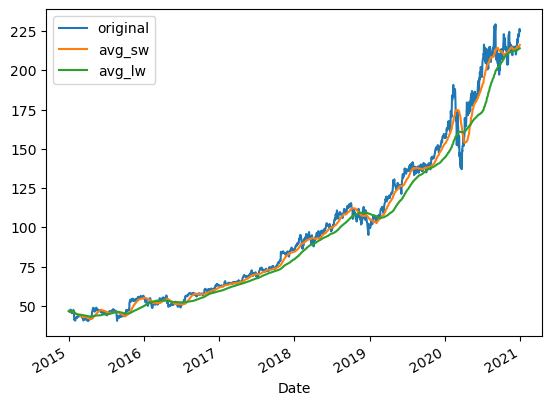

In [34]:
# отображаем скользящие средние на графике
plt.figure()
data['Open'].plot(label='original')
avg_sw.plot(label='avg_sw')
avg_lw.plot(label='avg_lw');
plt.legend()
plt.show()

In [35]:
# вводим сигналы и позиции
signal = pd.DataFrame(index = data.index)
signal['short_window']=avg_sw
signal['long_window']=avg_lw
signal['position'] = 0
signal.loc[signal['short_window'] > signal['long_window'], 'position'] = 1 
signal['signal'] = signal['position'].diff()
signal = signal.shift(1) #сдвинем, так как торги со следующего дня
signal = signal.iloc[1:]
signal

,short_window,long_window,position,signal
Date,,,,
2015-01-05,46.660000,46.660000,0.0,NaN
2015-01-06,46.514999,46.514999,0.0,0.0
2015-01-07,46.470000,46.470000,0.0,0.0
2015-01-08,46.347500,46.347500,0.0,0.0
2015-01-09,46.428000,46.428000,0.0,0.0
...,...,...,...,...
2020-12-23,214.617334,213.284222,1.0,0.0
2020-12-24,214.904334,213.434333,1.0,0.0
2020-12-28,215.205334,213.555333,1.0,0.0


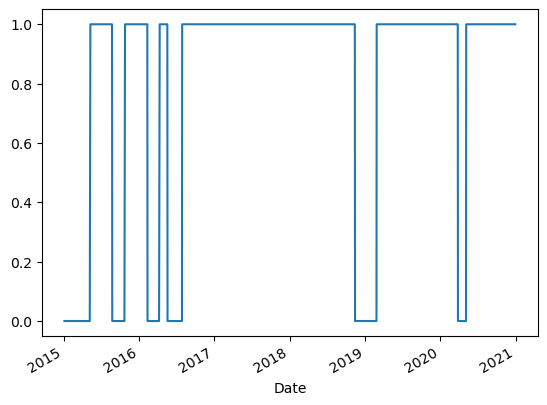

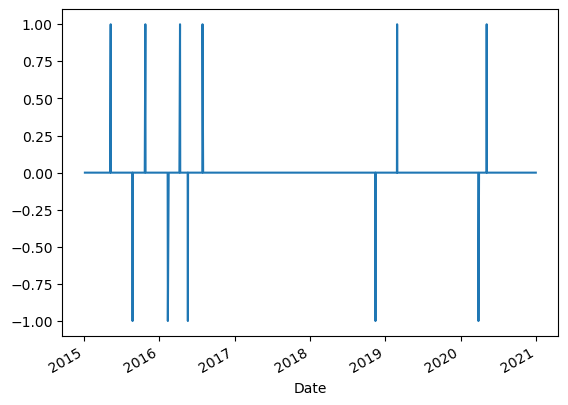

In [36]:
# бинарный график сигналов и позиций
signal['position'].plot() # 1 - в позиции, 0 - в кэше
plt.show()
signal['signal'].plot() #покупка - 1, продажа - -1
plt.show()

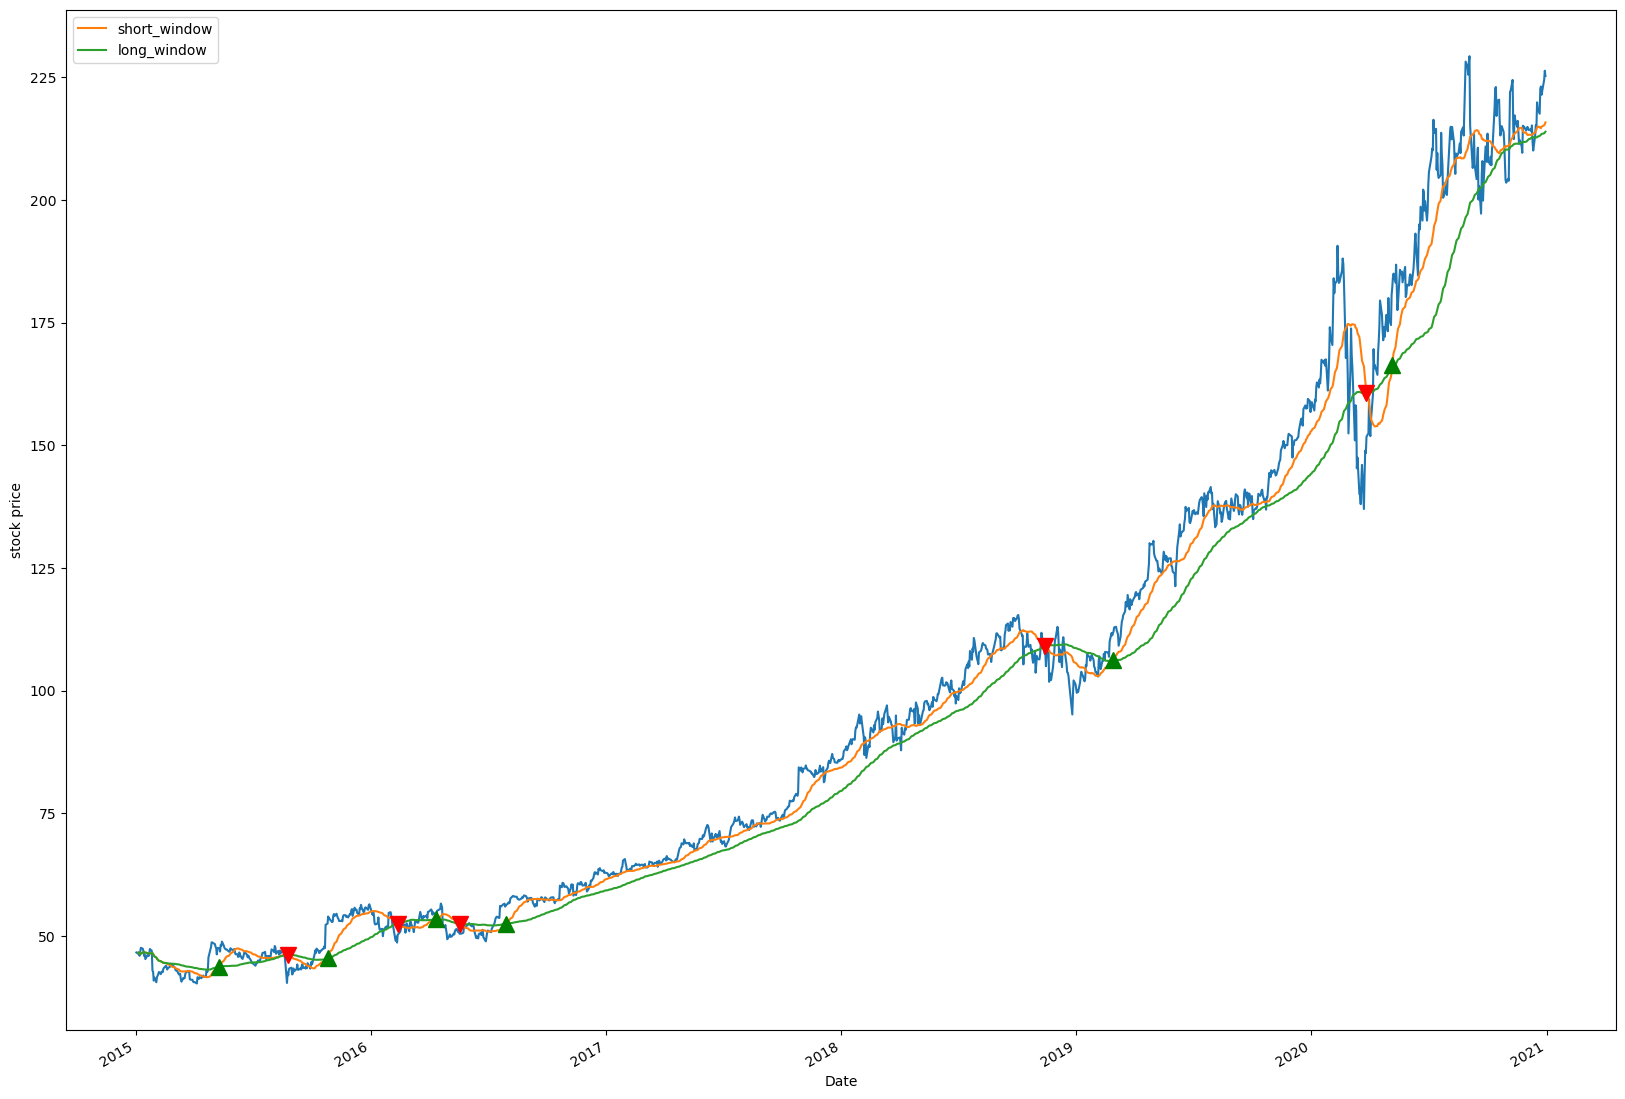

In [37]:
# отображаем сигналы на графике
fig = plt.figure(figsize=(20,15))
y = fig.add_subplot(ylabel='stock price')
data['Open'].plot(ax = y)
signal[['short_window', 'long_window']].plot(ax = y)
y.plot(
    signal.loc[signal['signal'] == 1].index, 
    signal.short_window[signal['signal'] == 1],
    '^', markersize=12, color='green')
y.plot(
    signal.loc[signal['signal'] == -1].index, 
    signal.short_window[signal['signal'] == -1],
    'v', markersize=12, color='red')         
plt.show()

In [38]:
# Объединим таблички
data = data.join(signal)
data

,Open,High,Low,Close,short_window,long_window,position,signal
Date,,,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,NaN,NaN,NaN,NaN
2015-01-05,46.369999,46.730000,46.250000,46.330002,46.660000,46.660000,0.0,NaN
2015-01-06,46.380001,46.750000,45.540001,45.650002,46.514999,46.514999,0.0,0.0
2015-01-07,45.980000,46.459999,45.490002,46.230000,46.470000,46.470000,0.0,0.0
2015-01-08,46.750000,47.750000,46.720001,47.590000,46.347500,46.347500,0.0,0.0
...,...,...,...,...,...,...,...,...
2020-12-23,223.110001,223.559998,220.800003,221.020004,214.617334,213.284222,1.0,0.0
2020-12-24,221.419998,223.610001,221.199997,222.750000,214.904334,213.434333,1.0,0.0
2020-12-28,224.449997,226.029999,223.020004,224.960007,215.205334,213.555333,1.0,0.0


In [39]:
# сигналы на покупку и продажу
signals = data[data['signal'].isin([1, -1])]
signals

,Open,High,Low,Close,short_window,long_window,position,signal
Date,,,,,,,,
2015-05-11,47.549999,47.910000,47.369999,47.369999,43.789000,43.721250,1.0,1.0
2015-08-25,42.570000,43.240002,40.389999,40.470001,46.194000,46.203555,0.0,-1.0
2015-10-26,52.529999,54.320000,52.500000,54.250000,45.578667,45.349555,1.0,1.0
2016-02-12,50.250000,50.680000,49.750000,50.500000,52.440333,52.582778,0.0,-1.0
2016-04-11,54.490002,55.150002,54.299999,54.310001,53.435000,53.350889,1.0,1.0
2016-05-19,50.470001,50.619999,49.820000,50.320000,52.440333,52.475111,0.0,-1.0
2016-07-29,56.259998,56.759998,56.049999,56.680000,52.516334,52.492667,1.0,1.0
2018-11-14,108.099998,108.260002,104.470001,104.970001,109.050334,109.135001,0.0,-1.0
2019-02-27,111.690002,112.360001,110.879997,112.169998,106.254334,106.054778,1.0,1.0


In [40]:
# расчет выручки без стоплоссов
bank = money 
shares_quantity = 0
amount = 0
possible_quantity = 0
result = pd.DataFrame()
for idx, row in signals.iterrows():
    if row.signal == 1:
        possible_quantity = bank // row.Open
        if possible_quantity > 0:
            shares_quantity = possible_quantity
            amount = shares_quantity * row.Open
            bank = bank % row.Open
            result = result.append(pd.Series({'Buy': "{:.2f}".format(amount), 'Sell': 0}, name=idx))
    else:
        if shares_quantity > 0:
            amount = shares_quantity * row.Open
            bank = bank + amount
            shares_quantity = 0
            result = result.append(pd.Series({'Buy': 0, 'Sell': "{:.2f}".format(amount)}, name=idx))
if shares_quantity > 0:
    bank += shares_quantity * data.iloc[-1].Close
    shares_quantity = 0
    result = result.append(pd.Series({'Buy': 0, 'Sell': "{:.2f}".format(bank)}, name=idx))

profit = bank - money
change = (bank / money - 1) * 100

print('денег после вывода ', bank)
print('прибыль ', profit, ', процентное изменение', change, '%')

display(result)

C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\2360739845.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\2360739845.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\2360739845.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\2360739845.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\2360739845.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

денег после вывода  2521116.247959137
прибыль  1521116.247959137 , процентное изменение 152.11162479591368 %


,Buy,Sell
2015-05-11,999976.48,0
2015-08-25,0,895247.09
2015-10-26,895268.77,0
2016-02-12,0,856410.75
2016-04-11,856364.87,0
2016-05-19,0,793186.54
2016-07-29,793209.72,0
2018-11-14,0,1524101.88
2019-02-27,1524121.77,0
2020-03-27,0,2070780.50


In [41]:
# расчет стоплоссов
signals['stop_loss_column'] = signals[signals['signal']==1].Open*(1 - stop_loss)
signals.loc[signals['signal'] == -1, 'stop_loss_column'] = 0
signals = pd.concat([signals, data[-1::]]) #последний день фрейма
display(signals)

C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\1643144428.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,short_window,long_window,position,signal,stop_loss_column
Date,,,,,,,,,
2015-05-11,47.549999,47.910000,47.369999,47.369999,43.789000,43.721250,1.0,1.0,45.172499
2015-08-25,42.570000,43.240002,40.389999,40.470001,46.194000,46.203555,0.0,-1.0,0.000000
2015-10-26,52.529999,54.320000,52.500000,54.250000,45.578667,45.349555,1.0,1.0,49.903499
2016-02-12,50.250000,50.680000,49.750000,50.500000,52.440333,52.582778,0.0,-1.0,0.000000
2016-04-11,54.490002,55.150002,54.299999,54.310001,53.435000,53.350889,1.0,1.0,51.765502
2016-05-19,50.470001,50.619999,49.820000,50.320000,52.440333,52.475111,0.0,-1.0,0.000000
2016-07-29,56.259998,56.759998,56.049999,56.680000,52.516334,52.492667,1.0,1.0,53.446998
2018-11-14,108.099998,108.260002,104.470001,104.970001,109.050334,109.135001,0.0,-1.0,0.000000
2019-02-27,111.690002,112.360001,110.879997,112.169998,106.254334,106.054778,1.0,1.0,106.105502


In [42]:
# нахожу стоп-лоссы между промежутками дат
loss = pd.DataFrame()
for i in range(12):
    if i % 2 == 0:
        loss = pd.concat([loss, data[(data.index > signals.index[i]) & (data.index < signals.index[i+1]) & 
                        (data.Open <= signals.stop_loss_column[i])].head(1)])
display(loss)

,Open,High,Low,Close,short_window,long_window,position,signal
Date,,,,,,,,
2015-06-29,45.040001,45.23,44.360001,44.369999,46.650,44.605333,1.0,0.0
2016-02-08,49.549999,49.57,48.189999,49.410000,53.309,52.350889,1.0,0.0
2016-04-27,51.480000,51.50,50.549999,50.939999,54.404,53.284889,1.0,0.0


In [43]:
# добавляю стоп-лоссы к сигналам
signals_and_stop_loss = pd.concat([signals, loss])
signals_and_stop_loss.sort_index(inplace=True)
display(signals_and_stop_loss)


,Open,High,Low,Close,short_window,long_window,position,signal,stop_loss_column
Date,,,,,,,,,
2015-05-11,47.549999,47.910000,47.369999,47.369999,43.789000,43.721250,1.0,1.0,45.172499
2015-06-29,45.040001,45.230000,44.360001,44.369999,46.650000,44.605333,1.0,0.0,NaN
2015-08-25,42.570000,43.240002,40.389999,40.470001,46.194000,46.203555,0.0,-1.0,0.000000
2015-10-26,52.529999,54.320000,52.500000,54.250000,45.578667,45.349555,1.0,1.0,49.903499
2016-02-08,49.549999,49.570000,48.189999,49.410000,53.309000,52.350889,1.0,0.0,NaN
2016-02-12,50.250000,50.680000,49.750000,50.500000,52.440333,52.582778,0.0,-1.0,0.000000
2016-04-11,54.490002,55.150002,54.299999,54.310001,53.435000,53.350889,1.0,1.0,51.765502
2016-04-27,51.480000,51.500000,50.549999,50.939999,54.404000,53.284889,1.0,0.0,NaN
2016-05-19,50.470001,50.619999,49.820000,50.320000,52.440333,52.475111,0.0,-1.0,0.000000


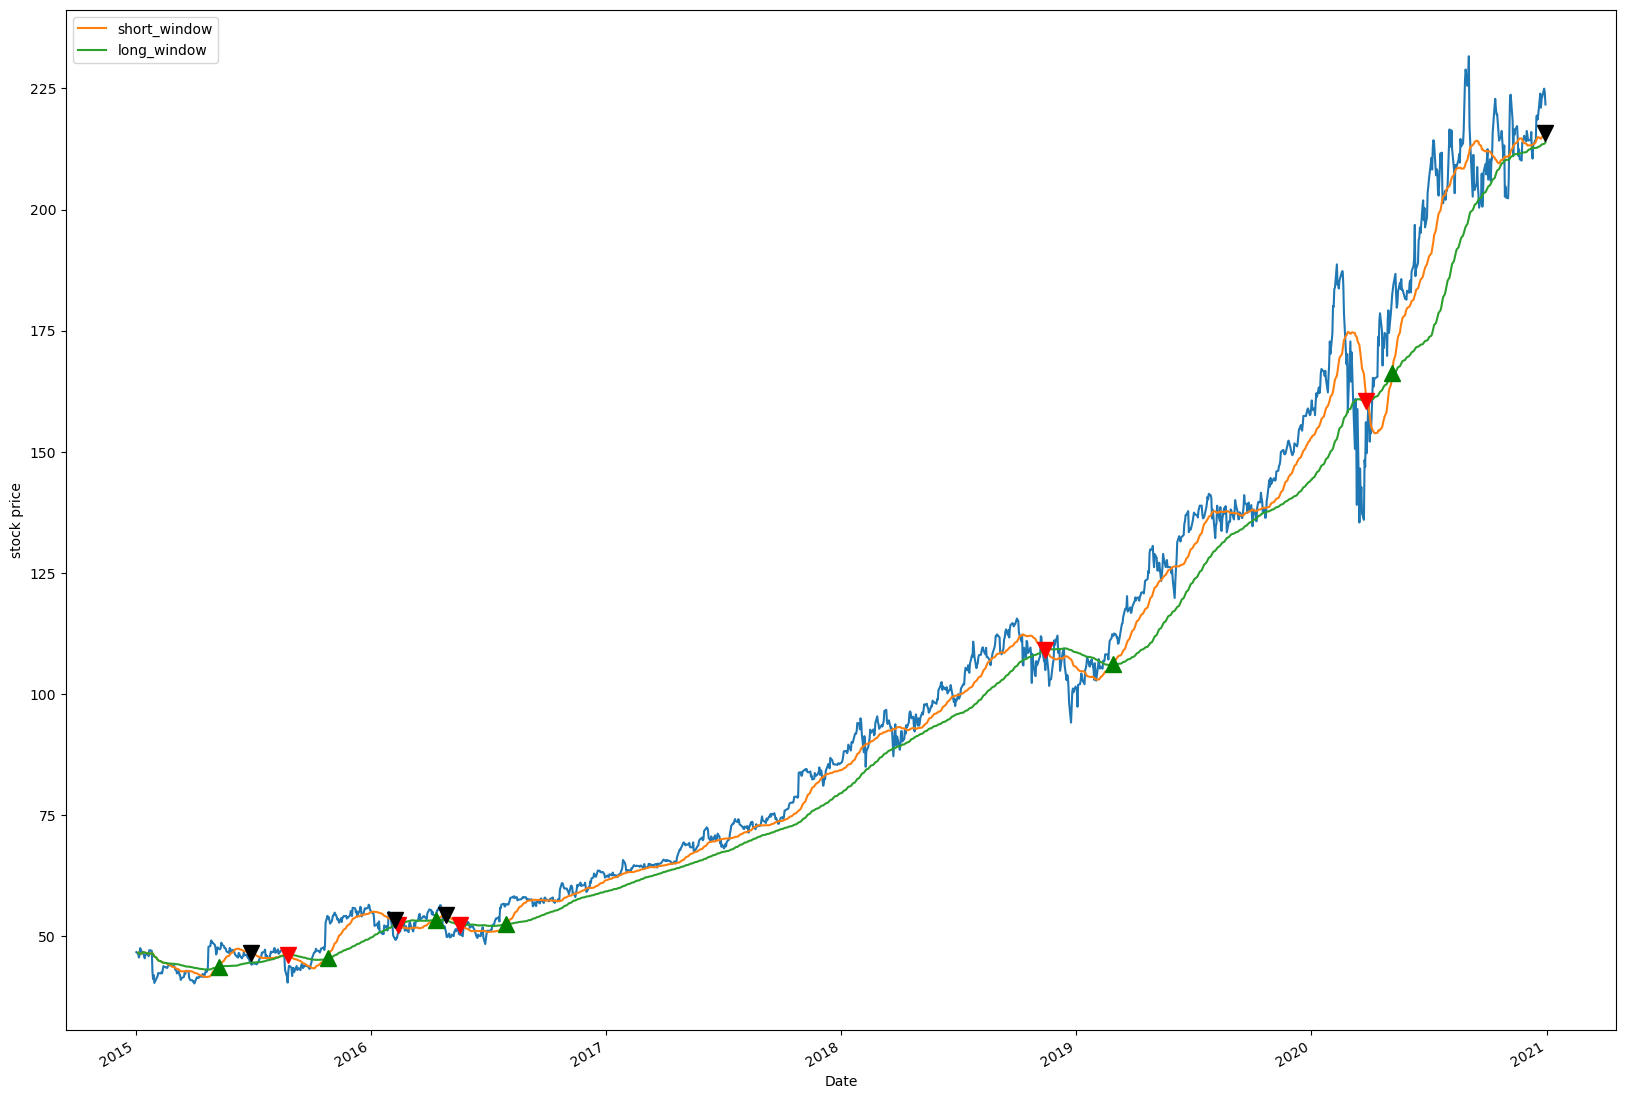

In [44]:
#  отображаем сигналы со стоп-лоссами на графике
fig = plt.figure(figsize=(20,15))
y = fig.add_subplot(ylabel='stock price')
data['Close'].plot(ax = y)
signal[['short_window', 'long_window']].plot(ax = y)

y.plot(
    signals_and_stop_loss.loc[signals_and_stop_loss.signal == 1].index, 
    signals_and_stop_loss.short_window[signals_and_stop_loss.signal == 1],
    '^', color='green', markersize=12
)

y.plot(
    signals_and_stop_loss.loc[signals_and_stop_loss.signal == -1].index, 
    signals_and_stop_loss.short_window[signals_and_stop_loss.signal == -1],
    'v', color='red',markersize=12
)

y.plot(
     signals_and_stop_loss.loc[signals_and_stop_loss.signal == 0].index, 
     signals_and_stop_loss.short_window[signals_and_stop_loss.signal == 0],
    'v', color='black', markersize=12
)
         
plt.show()

In [45]:
#прибыль со стоп-лоссами
bank = money 
shares_quantity = 0
amount = 0
possible_quantity = 0
result = pd.DataFrame()
for idx, row in signals_and_stop_loss.iterrows():
    if row.signal == 1:
        possible_quantity = bank // row.Open
        if possible_quantity > 0:
            shares_quantity = possible_quantity
            amount = shares_quantity * row.Open
            bank = bank % row.Open
            result = result.append(pd.Series({'Buy': "{:.2f}".format(amount), 'Sell': 0}, name=idx))
    else:
        if shares_quantity > 0:
            if row.signal == -1:
                amount = shares_quantity * row.Open
            else:
                amount = shares_quantity * row.Low
            amount = shares_quantity * row.Open
            bank = bank + amount
            shares_quantity = 0
            result = result.append(pd.Series({'Buy': 0, 'Sell': "{:.2f}".format(amount)}, name=idx))
if shares_quantity > 0:
    bank += shares_quantity * data.iloc[-1].Close
    shares_quantity = 0
    result = result.append(pd.Series({'Buy': 0, 'Sell': "{:.2f}".format(bank)}, name=idx))

profit = bank - money
change = (bank / money - 1) * 100

print('денег после вывода ', bank)
print('прибыль ', profit, ', процентное изменение', change, '%')

display(result)

денег после вывода  2725847.171497345
прибыль  1725847.171497345 , процентное изменение 172.5847171497345 %


C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\1984384902.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\1984384902.py:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\1984384902.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\1984384902.py:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\fenal\AppData\Local\Temp\ipykernel_2768\1984384902.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

,Buy,Sell
2015-05-11,999976.48,0
2015-06-29,0,947191.22
2015-10-26,947168.41,0
2016-02-08,0,893436.04
2016-04-11,893472.56,0
2016-04-27,0,844117.55
2016-07-29,844125.01,0
2018-11-14,0,1621932.38
2019-02-27,1621850.53,0
2020-03-27,0,2203561.75


In [52]:
# итоговый вариант со всеми покупками и продажами
data = signals_and_stop_loss.join(result)
data.reset_index(inplace= True)
data.drop(columns = ['stop_loss_column', 'position', 'short_window', 'long_window', 'High', 'Low', 'Close'], 
          index = [2,5,8], inplace = True)
data.loc[data['signal'] == 1, 'signal'] = 'buy'
data.loc[data['signal'] == 0, 'signal'] = 'stop_loss'
data.loc[data['signal'] == -1, 'signal'] = 'sale'
data.rename(columns = {'Open':'Share_price', 'Buy': 'Share_value', 'Sell': 'Cash'}, inplace = True)
data['num_shares'] = data['Share_value'].astype(float)//data['Share_price'].astype(float)
data.loc[data['signal'] == 'buy', 'Cash'] = data['Share_value'].astype(float) - (data['num_shares']*data['Share_price'].astype(float))
display(data)

,Date,Share_price,signal,Share_value,Cash,num_shares
0,2015-05-11,47.549999,buy,999976.48,47.546044,21029.0
1,2015-06-29,45.040001,stop_loss,0,947191.22,0.0
3,2015-10-26,52.529999,buy,947168.41,0.00201,18031.0
4,2016-02-08,49.549999,stop_loss,0,893436.04,0.0
6,2016-04-11,54.490002,buy,893472.56,0.002478,16397.0
7,2016-04-27,51.480000,stop_loss,0,844117.55,0.0
9,2016-07-29,56.259998,buy,844125.01,56.255182,15003.0
10,2018-11-14,108.099998,sale,0,1621932.38,0.0
11,2019-02-27,111.690002,buy,1621850.53,0.004548,14521.0
12,2020-03-27,151.750000,sale,0,2203561.75,0.0
